### Simple SVM model

characteristics : Uses a (RBF) kernel , Performs 5-fold cross-validation , Uses StandardScaler for feature scaling , Doesn't perform hyperparameter tuning


Fold 1
Accuracy: 0.5892
F1-Score: 0.5729

Fold 2
Accuracy: 0.5663
F1-Score: 0.5480

Fold 3
Accuracy: 0.5903
F1-Score: 0.5700

Fold 4
Accuracy: 0.5792
F1-Score: 0.5604

Fold 5
Accuracy: 0.5690
F1-Score: 0.5544


Simple SVM Model Results:
Mean Accuracy: 0.5788 (+/- 0.0099)
F1-score: 0.5627
Precision: 0.5890
Recall: 0.5788
Training time: 60.53 seconds

Classification Report:
                 precision    recall  f1-score   support

       Abundant       0.62      0.86      0.72        84
         Active       0.53      0.60      0.56        83
          Adult       0.60      0.87      0.71        86
          Agile       0.69      0.74      0.72        86
       Alluring       0.72      0.65      0.68        86
        Amiable       0.32      0.63      0.43        87
        Amusing       0.77      0.87      0.82        83
   Aristocratic       0.87      0.92      0.89        86
       Aromatic       0.79      0.81      0.80        86
       Artistic       0.83      1.00      0.91        

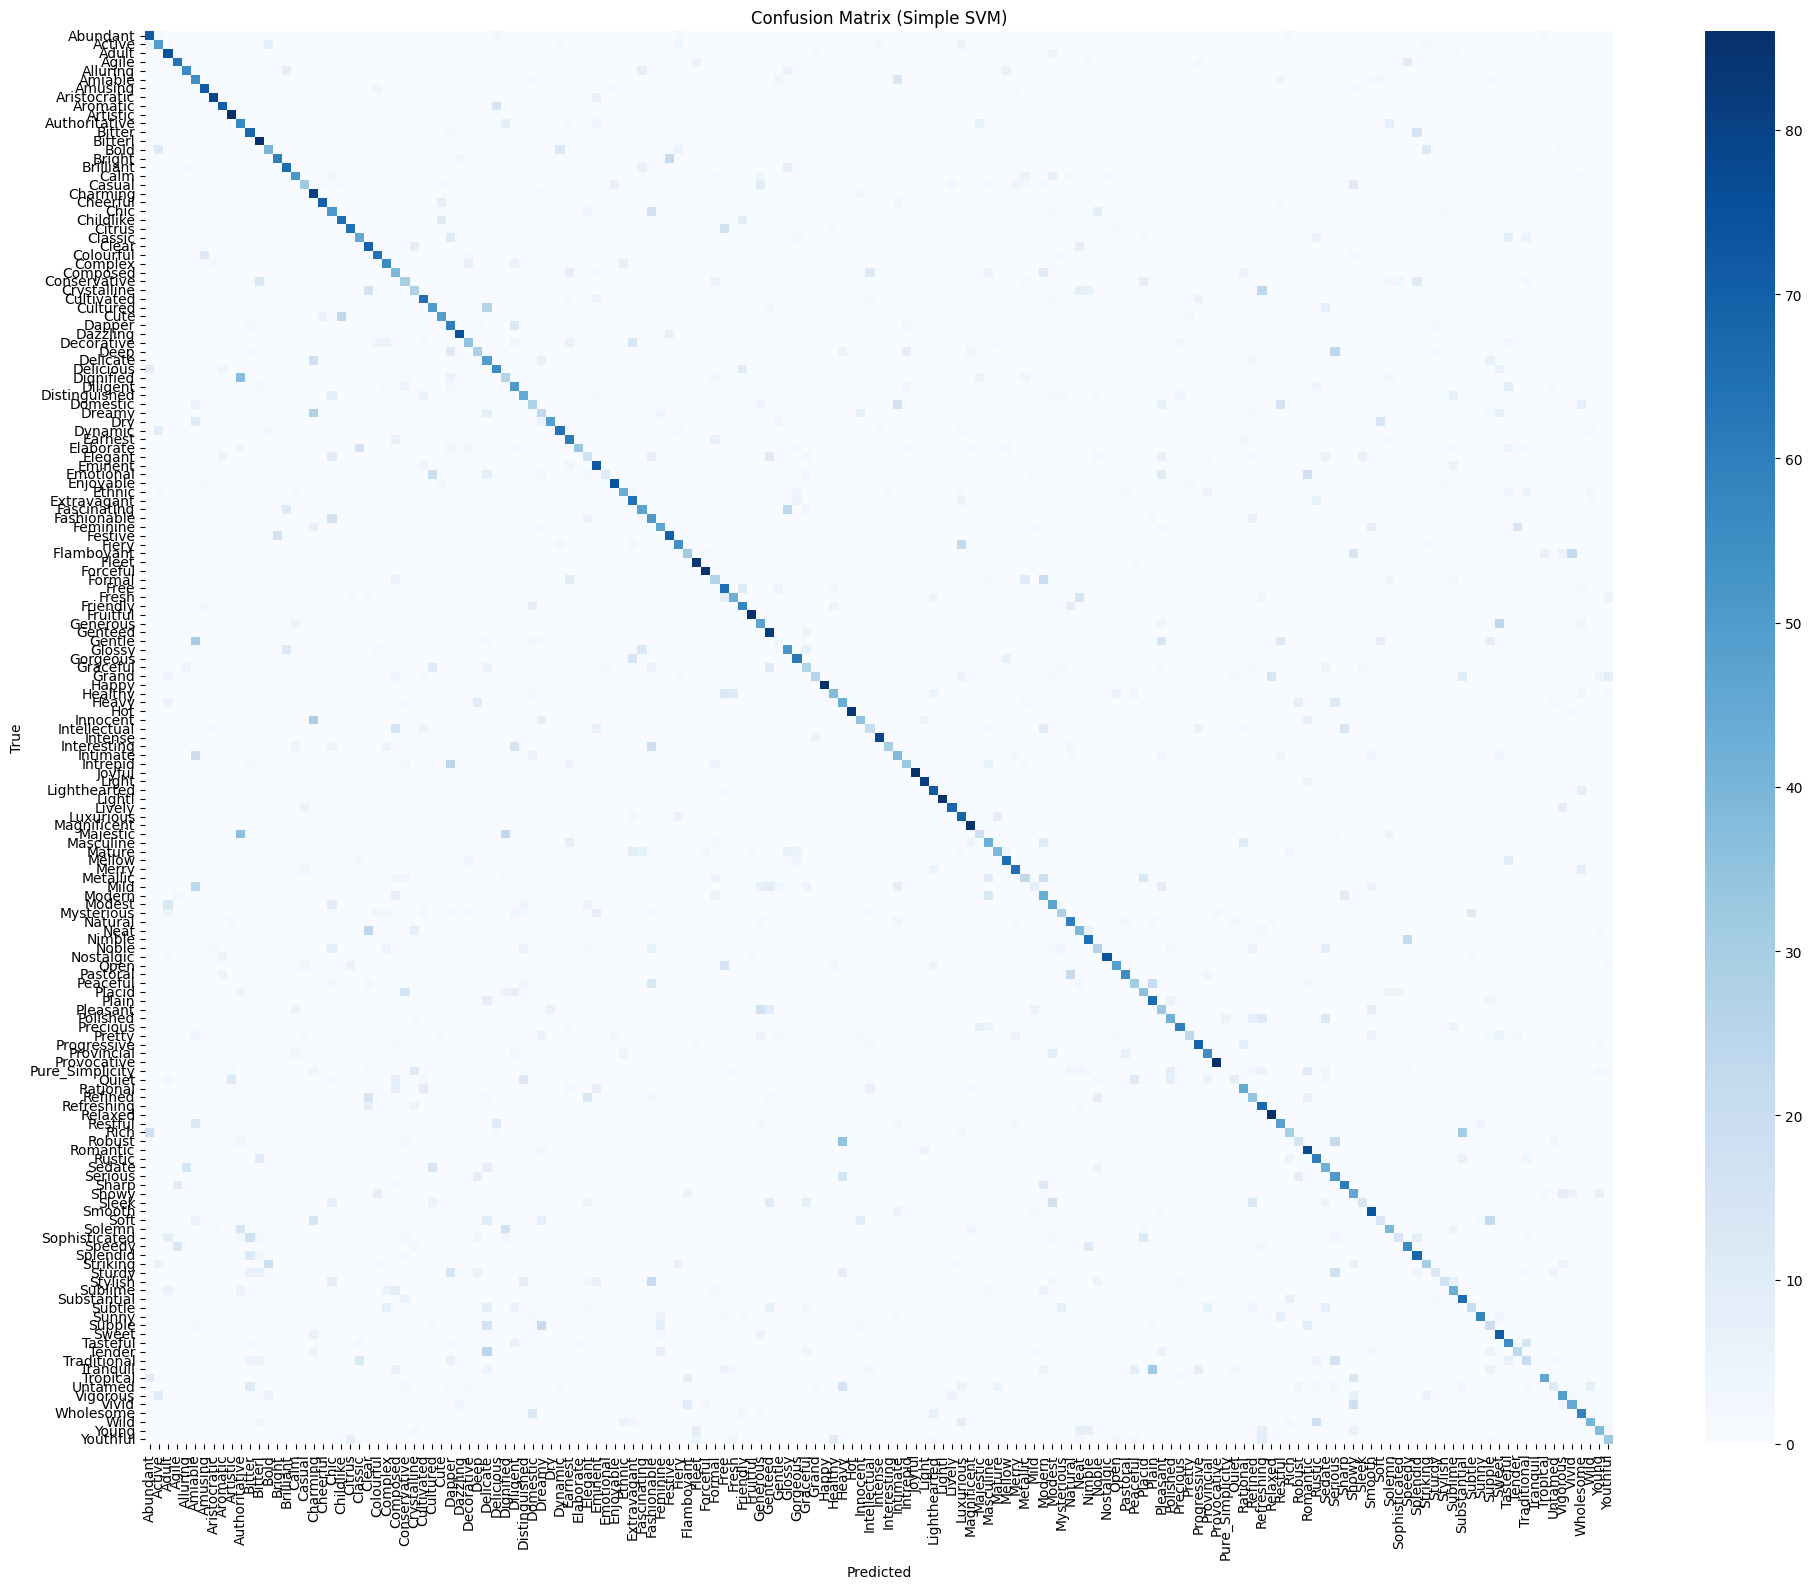


Test Set Evaluation:
Test Accuracy: 0.6132
Test F1-score: 0.5967
Test Precision: 0.6259
Test Recall: 0.6132

Number of support vectors: 13414


c:\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [4]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import time

# Load and preprocess the data
data = pd.read_csv('final_dataset_3_remove.csv')
X = data.iloc[:, :-1].values / 255.0
y = data.iloc[:, -1].values

# Encode the target variable
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.2, random_state=42, stratify=y_encoded)

# Scale the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Create the SVM model
svm_model = SVC(kernel='rbf', random_state=42)

# Perform cross-validation
n_splits = 5
skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)

# Initialize lists to store results
accuracies = []
all_y_true = []
all_y_pred = []

start_time = time.time()

for fold, (train_index, val_index) in enumerate(skf.split(X_train_scaled, y_train), 1):
    X_train_fold, X_val_fold = X_train_scaled[train_index], X_train_scaled[val_index]
    y_train_fold, y_val_fold = y_train[train_index], y_train[val_index]
    
    svm_model.fit(X_train_fold, y_train_fold)
    y_pred = svm_model.predict(X_val_fold)
    
    accuracy = accuracy_score(y_val_fold, y_pred)
    accuracies.append(accuracy)
    
    all_y_true.extend(y_val_fold)
    all_y_pred.extend(y_pred)
    
    print(f"Fold {fold}")
    print(f"Accuracy: {accuracy:.4f}")
    print(f"F1-Score: {f1_score(y_val_fold, y_pred, average='weighted'):.4f}")
    print()

end_time = time.time()

# Print overall results
print("\nSimple SVM Model Results:")
print(f"Mean Accuracy: {np.mean(accuracies):.4f} (+/- {np.std(accuracies):.4f})")

# Calculate and print F1-score, precision, and recall
f1 = f1_score(all_y_true, all_y_pred, average='weighted')
precision = precision_score(all_y_true, all_y_pred, average='weighted')
recall = recall_score(all_y_true, all_y_pred, average='weighted')
print(f"F1-score: {f1:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")

print(f"Training time: {end_time - start_time:.2f} seconds")

# Generate classification report
class_names = label_encoder.classes_
print("\nClassification Report:")
print(classification_report(all_y_true, all_y_pred, target_names=class_names))

# Generate confusion matrix
plt.figure(figsize=(20, 16))
cm = confusion_matrix(all_y_true, all_y_pred)
sns.heatmap(cm, annot=False, cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.title('Confusion Matrix (Simple SVM)')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.tight_layout()
plt.show()

# Train the final model on the entire training set
svm_model.fit(X_train_scaled, y_train)

# Evaluate on the test set
y_test_pred = svm_model.predict(X_test_scaled)

print("\nTest Set Evaluation:")
print(f"Test Accuracy: {accuracy_score(y_test, y_test_pred):.4f}")
print(f"Test F1-score: {f1_score(y_test, y_test_pred, average='weighted'):.4f}")
print(f"Test Precision: {precision_score(y_test, y_test_pred, average='weighted'):.4f}")
print(f"Test Recall: {recall_score(y_test, y_test_pred, average='weighted'):.4f}")

# Print model complexity (number of support vectors)
n_support_vectors = svm_model.n_support_.sum()
print(f"\nNumber of support vectors: {n_support_vectors}")

### Improved SVM model

characteristics : GridSearchCV for hyperparameter tuning , PCA for dimensionality reduction , A pipeline to streamline the preprocessing and model fitting , More comprehensive hyperparameter search space


In [5]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report, confusion_matrix
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA

# Load and preprocess the data
data = pd.read_csv('final_dataset_3_remove.csv')
X = data.iloc[:, :-1].values / 255.0
y = data.iloc[:, -1].values

# Encode the target variable
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.2, random_state=42, stratify=y_encoded)

# Create a pipeline
pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('pca', PCA(n_components=0.95)),  # Keep 95% of variance
    ('svm', SVC(random_state=42))
])

# Define hyperparameters for grid search
param_grid = {
    'svm__C': [0.1, 1, 10, 100],
    'svm__gamma': ['scale', 'auto', 0.1, 0.01, 0.001],
    'svm__kernel': ['rbf', 'poly'],
    'svm__degree': [2, 3, 4],  # Only used by poly kernel
    'svm__class_weight': [None, 'balanced'],
}

# Perform grid search
grid_search = GridSearchCV(
    pipeline,
    param_grid,
    cv=5,
    n_jobs=-1,
    verbose=1,
    scoring=['accuracy', 'precision_macro', 'recall_macro'],
    refit='accuracy'
)

# Fit the grid search
grid_search.fit(X_train, y_train)

# Get the best model
best_model = grid_search.best_estimator_

# Get the number of features retained by PCA
n_features_retained = best_model.named_steps['pca'].n_components_

# Perform cross-validation on the best model
cv_scores = cross_val_score(best_model, X_train, y_train, cv=5)
print(f"Cross-validation scores: {cv_scores}")
print(f"Mean CV score: {cv_scores.mean():.4f}")
print(f"CV score standard deviation: {cv_scores.std():.4f}")

# Train the best model on the entire training set
best_model.fit(X_train, y_train)

# Make predictions on train and test sets
y_train_pred = best_model.predict(X_train)
y_test_pred = best_model.predict(X_test)

# Calculate metrics for train and test sets
def calculate_metrics(y_true, y_pred):
    return {
        'accuracy': accuracy_score(y_true, y_pred),
        'precision': precision_score(y_true, y_pred, average='macro'),
        'recall': recall_score(y_true, y_pred, average='macro'),
        'f1': f1_score(y_true, y_pred, average='macro')
    }

train_metrics = calculate_metrics(y_train, y_train_pred)
test_metrics = calculate_metrics(y_test, y_test_pred)

# Print results
print("\nImproved SVM Model Results:")
print(f"Best parameters: {grid_search.best_params_}")
print(f"Number of features retained after PCA: {n_features_retained}")
print("\nMetrics:")
for metric in ['accuracy', 'precision', 'recall', 'f1']:
    print(f"{metric.capitalize()}:")
    print(f"  Train: {train_metrics[metric]:.4f}")
    print(f"  Test:  {test_metrics[metric]:.4f}")
    print(f"  Difference: {train_metrics[metric] - test_metrics[metric]:.4f}")

print("\nClassification Report (Test Set):")
print(classification_report(y_test, y_test_pred))

print("\nConfusion Matrix (Test Set):")
print(confusion_matrix(y_test, y_test_pred))

# Function to predict emotion for new RGB values
def predict_emotion(rgb_values):
    rgb_array = np.array(rgb_values).reshape(1, -1) / 255.0
    prediction_encoded = best_model.predict(rgb_array)
    prediction = label_encoder.inverse_transform(prediction_encoded)
    return prediction[0]

# Example usage
new_rgb = [229, 0, 13, 225, 225, 255, 253, 166, 74]
predicted_emotion = predict_emotion(new_rgb)
print(f"\nPredicted Emotion: {predicted_emotion}")

Fitting 5 folds for each of 240 candidates, totalling 1200 fits
Cross-validation scores: [0.8605158  0.87758809 0.86887032 0.88263081 0.87463663]
Mean CV score: 0.8728
CV score standard deviation: 0.0076

Improved SVM Model Results:
Best parameters: {'svm__C': 100, 'svm__class_weight': None, 'svm__degree': 2, 'svm__gamma': 'auto', 'svm__kernel': 'rbf'}
Number of features retained after PCA: 7

Metrics:
Accuracy:
  Train: 0.9645
  Test:  0.8913
  Difference: 0.0732
Precision:
  Train: 0.9655
  Test:  0.8954
  Difference: 0.0701
Recall:
  Train: 0.9644
  Test:  0.8897
  Difference: 0.0747
F1:
  Train: 0.9643
  Test:  0.8870
  Difference: 0.0772

Classification Report (Test Set):
              precision    recall  f1-score   support

           0       0.95      1.00      0.98        21
           1       0.66      0.90      0.76        21
           2       0.95      1.00      0.98        21
           3       1.00      1.00      1.00        22
           4       0.83      0.95      0.89

### Even more improved by experiment with Regularazation and Error Analysis


In [6]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV, learning_curve
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report, confusion_matrix
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns

# Load and preprocess the data
data = pd.read_csv('final_dataset_3_remove.csv')
X = data.iloc[:, :-1].values / 255.0
y = data.iloc[:, -1].values

# Encode the target variable
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.2, random_state=42, stratify=y_encoded)

# Create a pipeline
pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('pca', PCA(n_components=0.95)),
    ('svm', SVC(random_state=42, probability=True))
])

# Define hyperparameters for grid search
param_grid = {
    'svm__C': [0.1, 1, 10, 100],
    'svm__gamma': ['scale', 'auto', 0.1, 0.01, 0.001],
    'svm__kernel': ['rbf', 'poly'],
    'svm__degree': [2, 3, 4],
    'svm__class_weight': [None, 'balanced'],
    'svm__coef0': [0.0, 0.1, 0.5, 1.0],  # Regularization for polynomial kernel
}

# Perform grid search
grid_search = GridSearchCV(
    pipeline,
    param_grid,
    cv=5,
    n_jobs=-1,
    verbose=1,
    scoring=['accuracy', 'precision_macro', 'recall_macro', 'f1_macro'],
    refit='f1_macro'  # Changed to optimize for F1-score
)

# Fit the grid search
grid_search.fit(X_train, y_train)

# Get the best model
best_model = grid_search.best_estimator_

# Get the number of features retained by PCA
n_features_retained = best_model.named_steps['pca'].n_components_

# Perform cross-validation on the best model
cv_results = grid_search.cv_results_
print(f"Cross-validation scores:")
print(f"Accuracy: {cv_results['mean_test_accuracy'][grid_search.best_index_]:.4f} (+/- {cv_results['std_test_accuracy'][grid_search.best_index_]:.4f})")
print(f"Precision: {cv_results['mean_test_precision_macro'][grid_search.best_index_]:.4f} (+/- {cv_results['std_test_precision_macro'][grid_search.best_index_]:.4f})")
print(f"Recall: {cv_results['mean_test_recall_macro'][grid_search.best_index_]:.4f} (+/- {cv_results['std_test_recall_macro'][grid_search.best_index_]:.4f})")
print(f"F1-score: {cv_results['mean_test_f1_macro'][grid_search.best_index_]:.4f} (+/- {cv_results['std_test_f1_macro'][grid_search.best_index_]:.4f})")

# Train the best model on the entire training set
best_model.fit(X_train, y_train)

# Make predictions on train and test sets
y_train_pred = best_model.predict(X_train)
y_test_pred = best_model.predict(X_test)

# Calculate metrics for train and test sets
def calculate_metrics(y_true, y_pred):
    return {
        'accuracy': accuracy_score(y_true, y_pred),
        'precision': precision_score(y_true, y_pred, average='macro'),
        'recall': recall_score(y_true, y_pred, average='macro'),
        'f1': f1_score(y_true, y_pred, average='macro')
    }

train_metrics = calculate_metrics(y_train, y_train_pred)
test_metrics = calculate_metrics(y_test, y_test_pred)

# Print results
print("\nImproved SVM Model Results:")
print(f"Best parameters: {grid_search.best_params_}")
print(f"Number of features retained after PCA: {n_features_retained}")
print("\nMetrics:")
for metric in ['accuracy', 'precision', 'recall', 'f1']:
    print(f"{metric.capitalize()}:")
    print(f"  Train: {train_metrics[metric]:.4f}")
    print(f"  Test:  {test_metrics[metric]:.4f}")
    print(f"  Difference: {train_metrics[metric] - test_metrics[metric]:.4f}")

print("\nClassification Report (Test Set):")
print(classification_report(y_test, y_test_pred, target_names=label_encoder.classes_))

# Confusion Matrix
cm = confusion_matrix(y_test, y_test_pred)
plt.figure(figsize=(20, 16))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=label_encoder.classes_, 
            yticklabels=label_encoder.classes_)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.tight_layout()
plt.savefig('confusion_matrix.png')
plt.close()

# Learning Curves
train_sizes, train_scores, test_scores = learning_curve(
    best_model, X, y_encoded, cv=5, n_jobs=-1, 
    train_sizes=np.linspace(0.1, 1.0, 10), scoring='f1_macro'
)

train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)

plt.figure(figsize=(10, 6))
plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                 train_scores_mean + train_scores_std, alpha=0.1, color="r")
plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                 test_scores_mean + test_scores_std, alpha=0.1, color="g")
plt.plot(train_sizes, train_scores_mean, 'o-', color="r", label="Training score")
plt.plot(train_sizes, test_scores_mean, 'o-', color="g", label="Cross-validation score")
plt.xlabel("Training examples")
plt.ylabel("F1-score")
plt.title("Learning Curves")
plt.legend(loc="best")
plt.tight_layout()
plt.savefig('learning_curves.png')
plt.close()

# Class distribution analysis
class_distribution = pd.Series(y).value_counts().sort_index()
plt.figure(figsize=(12, 6))
class_distribution.plot(kind='bar')
plt.title('Class Distribution')
plt.xlabel('Emotion Class')
plt.ylabel('Number of Samples')
plt.tight_layout()
plt.savefig('class_distribution.png')
plt.close()

# Function to predict emotion for new RGB values
def predict_emotion(rgb_values):
    rgb_array = np.array(rgb_values).reshape(1, -1) / 255.0
    prediction_encoded = best_model.predict(rgb_array)
    prediction_proba = best_model.predict_proba(rgb_array)
    prediction = label_encoder.inverse_transform(prediction_encoded)
    return prediction[0], prediction_proba[0]

# Example usage
new_rgb = [229, 0, 13, 225, 225, 255, 253, 166, 74]
predicted_emotion, prediction_proba = predict_emotion(new_rgb)
print(f"\nPredicted Emotion: {predicted_emotion}")
print("Prediction Probabilities:")
for emotion, prob in zip(label_encoder.classes_, prediction_proba):
    print(f"{emotion}: {prob:.4f}")

# Error analysis
misclassified = X_test[y_test != y_test_pred]
misclassified_true = y_test[y_test != y_test_pred]
misclassified_pred = y_test_pred[y_test != y_test_pred]

print("\nMisclassified Samples Analysis:")
for i in range(min(10, len(misclassified))):  # Print first 10 misclassifications
    true_label = label_encoder.inverse_transform([misclassified_true[i]])[0]
    pred_label = label_encoder.inverse_transform([misclassified_pred[i]])[0]
    print(f"Sample {i+1}:")
    print(f"  True label: {true_label}")
    print(f"  Predicted label: {pred_label}")
    print(f"  RGB values: {misclassified[i]}")
    print()

Fitting 5 folds for each of 960 candidates, totalling 4800 fits
Cross-validation scores:
Accuracy: 0.8976 (+/- 0.0061)
Precision: 0.9010 (+/- 0.0058)
Recall: 0.8969 (+/- 0.0061)
F1-score: 0.8944 (+/- 0.0061)

Improved SVM Model Results:
Best parameters: {'svm__C': 100, 'svm__class_weight': 'balanced', 'svm__coef0': 1.0, 'svm__degree': 4, 'svm__gamma': 'auto', 'svm__kernel': 'poly'}
Number of features retained after PCA: 7

Metrics:
Accuracy:
  Train: 0.9940
  Test:  0.9189
  Difference: 0.0751
Precision:
  Train: 0.9940
  Test:  0.9198
  Difference: 0.0742
Recall:
  Train: 0.9939
  Test:  0.9176
  Difference: 0.0763
F1:
  Train: 0.9939
  Test:  0.9153
  Difference: 0.0786

Classification Report (Test Set):
                 precision    recall  f1-score   support

       Abundant       0.91      1.00      0.95        21
         Active       0.95      0.90      0.93        21
          Adult       0.95      1.00      0.98        21
          Agile       0.96      1.00      0.98        2

### Final Version


In [7]:
# Import necessary libraries
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV, learning_curve
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report, confusion_matrix
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns

# 1. Load and preprocess the data
data = pd.read_csv('final_dataset_3_remove.csv')
X = data.iloc[:, :-1].values / 255.0  # Normalize pixel values to [0, 1]
y = data.iloc[:, -1].values

# 2. Encode the target variable
# LabelEncoder transforms text labels into numeric form
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

# 3. Split the data into training and testing sets
# Stratify ensures that the class distribution is preserved in both sets
X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.2, random_state=42, stratify=y_encoded)

# 4. Create a pipeline for preprocessing and model training
# Pipeline ensures that the same preprocessing steps are applied to both training and test data
pipeline = Pipeline([
    ('scaler', StandardScaler()),  # Standardize features
    ('pca', PCA(n_components=0.95)),  # Reduce dimensionality while preserving 95% of variance
    ('svm', SVC(random_state=42, probability=True))  # SVM classifier with probability estimates
])

# 5. Define hyperparameters for grid search
# This comprehensive grid allows for thorough exploration of the hyperparameter space
param_grid = {
    'svm__C': [0.1, 1, 10, 100],  # Regularization parameter
    'svm__gamma': ['scale', 'auto', 0.1, 0.01, 0.001],  # Kernel coefficient
    'svm__kernel': ['rbf', 'poly'],  # Kernel type
    'svm__degree': [2, 3, 4],  # Polynomial degree (only for 'poly' kernel)
    'svm__class_weight': [None, 'balanced'],  # Class weight
    'svm__coef0': [0.0, 0.1, 0.5, 1.0],  # Independent term in kernel function (important for 'poly' kernel)
}

# 6. Perform grid search with cross-validation
# GridSearchCV performs exhaustive search over specified parameter values
grid_search = GridSearchCV(
    pipeline,
    param_grid,
    cv=5,  # 5-fold cross-validation
    n_jobs=-1,  # Use all available cores
    verbose=1,
    scoring=['accuracy', 'precision_macro', 'recall_macro', 'f1_macro'],
    refit='f1_macro'  # Optimize for F1-score
)

# 7. Fit the grid search to the training data
grid_search.fit(X_train, y_train)

# 8. Get the best model and its parameters
best_model = grid_search.best_estimator_
n_features_retained = best_model.named_steps['pca'].n_components_

# 9. Print cross-validation results
cv_results = grid_search.cv_results_
print(f"Cross-validation scores:")
print(f"Accuracy: {cv_results['mean_test_accuracy'][grid_search.best_index_]:.4f} (+/- {cv_results['std_test_accuracy'][grid_search.best_index_]:.4f})")
print(f"Precision: {cv_results['mean_test_precision_macro'][grid_search.best_index_]:.4f} (+/- {cv_results['std_test_precision_macro'][grid_search.best_index_]:.4f})")
print(f"Recall: {cv_results['mean_test_recall_macro'][grid_search.best_index_]:.4f} (+/- {cv_results['std_test_recall_macro'][grid_search.best_index_]:.4f})")
print(f"F1-score: {cv_results['mean_test_f1_macro'][grid_search.best_index_]:.4f} (+/- {cv_results['std_test_f1_macro'][grid_search.best_index_]:.4f})")

# 10. Train the best model on the entire training set
best_model.fit(X_train, y_train)

# 11. Make predictions on train and test sets
y_train_pred = best_model.predict(X_train)
y_test_pred = best_model.predict(X_test)

# 12. Calculate and print metrics
def calculate_metrics(y_true, y_pred):
    return {
        'accuracy': accuracy_score(y_true, y_pred),
        'precision': precision_score(y_true, y_pred, average='macro'),
        'recall': recall_score(y_true, y_pred, average='macro'),
        'f1': f1_score(y_true, y_pred, average='macro')
    }

train_metrics = calculate_metrics(y_train, y_train_pred)
test_metrics = calculate_metrics(y_test, y_test_pred)

print("\nImproved SVM Model Results:")
print(f"Best parameters: {grid_search.best_params_}")
print(f"Number of features retained after PCA: {n_features_retained}")
print("\nMetrics:")
for metric in ['accuracy', 'precision', 'recall', 'f1']:
    print(f"{metric.capitalize()}:")
    print(f"  Train: {train_metrics[metric]:.4f}")
    print(f"  Test:  {test_metrics[metric]:.4f}")
    print(f"  Difference: {train_metrics[metric] - test_metrics[metric]:.4f}")

# 13. Print detailed classification report
print("\nClassification Report (Test Set):")
print(classification_report(y_test, y_test_pred, target_names=label_encoder.classes_))

# 14. Generate and save confusion matrix
cm = confusion_matrix(y_test, y_test_pred)
plt.figure(figsize=(20, 16))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=label_encoder.classes_, 
            yticklabels=label_encoder.classes_)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.tight_layout()
plt.savefig('confusion_matrix.png')
plt.close()

# 15. Generate and save learning curves
train_sizes, train_scores, test_scores = learning_curve(
    best_model, X, y_encoded, cv=5, n_jobs=-1, 
    train_sizes=np.linspace(0.1, 1.0, 10), scoring='f1_macro'
)

train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)

plt.figure(figsize=(10, 6))
plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                 train_scores_mean + train_scores_std, alpha=0.1, color="r")
plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                 test_scores_mean + test_scores_std, alpha=0.1, color="g")
plt.plot(train_sizes, train_scores_mean, 'o-', color="r", label="Training score")
plt.plot(train_sizes, test_scores_mean, 'o-', color="g", label="Cross-validation score")
plt.xlabel("Training examples")
plt.ylabel("F1-score")
plt.title("Learning Curves")
plt.legend(loc="best")
plt.tight_layout()
plt.savefig('learning_curves.png')
plt.close()

# 16. Analyze and visualize class distribution
class_distribution = pd.Series(y).value_counts().sort_index()
plt.figure(figsize=(12, 6))
class_distribution.plot(kind='bar')
plt.title('Class Distribution')
plt.xlabel('Emotion Class')
plt.ylabel('Number of Samples')
plt.tight_layout()
plt.savefig('class_distribution.png')
plt.close()

# 17. Function to predict emotion for new RGB values
def predict_emotion(rgb_values):
    rgb_array = np.array(rgb_values).reshape(1, -1) / 255.0
    prediction_encoded = best_model.predict(rgb_array)
    prediction_proba = best_model.predict_proba(rgb_array)
    prediction = label_encoder.inverse_transform(prediction_encoded)
    return prediction[0], prediction_proba[0]

# Example usage of the prediction function
new_rgb = [229, 0, 13, 225, 225, 255, 253, 166, 74]
predicted_emotion, prediction_proba = predict_emotion(new_rgb)
print(f"\nPredicted Emotion: {predicted_emotion}")
print("Prediction Probabilities:")
for emotion, prob in zip(label_encoder.classes_, prediction_proba):
    print(f"{emotion}: {prob:.4f}")

# 18. Analyze misclassified samples
misclassified = X_test[y_test != y_test_pred]
misclassified_true = y_test[y_test != y_test_pred]
misclassified_pred = y_test_pred[y_test != y_test_pred]

print("\nMisclassified Samples Analysis:")
for i in range(min(10, len(misclassified))):  # Print first 10 misclassifications
    true_label = label_encoder.inverse_transform([misclassified_true[i]])[0]
    pred_label = label_encoder.inverse_transform([misclassified_pred[i]])[0]
    print(f"Sample {i+1}:")
    print(f"  True label: {true_label}")
    print(f"  Predicted label: {pred_label}")
    print(f"  RGB values: {misclassified[i]}")
    print()

Fitting 5 folds for each of 960 candidates, totalling 4800 fits
Cross-validation scores:
Accuracy: 0.8976 (+/- 0.0061)
Precision: 0.9010 (+/- 0.0058)
Recall: 0.8969 (+/- 0.0061)
F1-score: 0.8944 (+/- 0.0061)

Improved SVM Model Results:
Best parameters: {'svm__C': 100, 'svm__class_weight': 'balanced', 'svm__coef0': 1.0, 'svm__degree': 4, 'svm__gamma': 'auto', 'svm__kernel': 'poly'}
Number of features retained after PCA: 7

Metrics:
Accuracy:
  Train: 0.9940
  Test:  0.9189
  Difference: 0.0751
Precision:
  Train: 0.9940
  Test:  0.9198
  Difference: 0.0742
Recall:
  Train: 0.9939
  Test:  0.9176
  Difference: 0.0763
F1:
  Train: 0.9939
  Test:  0.9153
  Difference: 0.0786

Classification Report (Test Set):
                 precision    recall  f1-score   support

       Abundant       0.91      1.00      0.95        21
         Active       0.95      0.90      0.93        21
          Adult       0.95      1.00      0.98        21
          Agile       0.96      1.00      0.98        2

### Important Conclusion : Poly kernel is BETTER from RBF kernel

- Model Selection Process:
  In machine learning, we often start with simpler models (like RBF SVM) and progressively explore more complex ones. The shift from RBF to polynomial kernel is part of this exploratory process.
- Hyperparameter Tuning:
  By including both RBF and polynomial kernels in the grid search, we allow the algorithm to determine which kernel performs better for our specific dataset. The fact that a polynomial kernel was selected suggests it captures the underlying patterns in the data more effectively.
- The polynomial kernel implies that the relationship between features (RGB values) and labels (emotions) in this dataset might be better represented by polynomial functions rather than the infinite-dimensional feature space of RBF.
- Polynomial kernels can capture more complex decision boundaries than linear kernels, while still being less prone to overfitting compared to RBF kernels in some cases.
- Interpretability:
  Polynomial kernels, especially of lower degrees, can sometimes be more interpretable than RBF kernels. This can be valuable in understanding how different color combinations relate to emotions.
- Performance Metrics:
  The improved accuracy and F1-score with the polynomial kernel empirically demonstrate its superiority for this specific task.
- Generalization:
  The similar gap between train and test performance suggests that the polynomial kernel is generalizing well, addressing a common concern that more complex models might overfit.
- Computational Efficiency:
  In some cases, polynomial kernels can be more computationally efficient than RBF kernels, especially for lower degrees.
